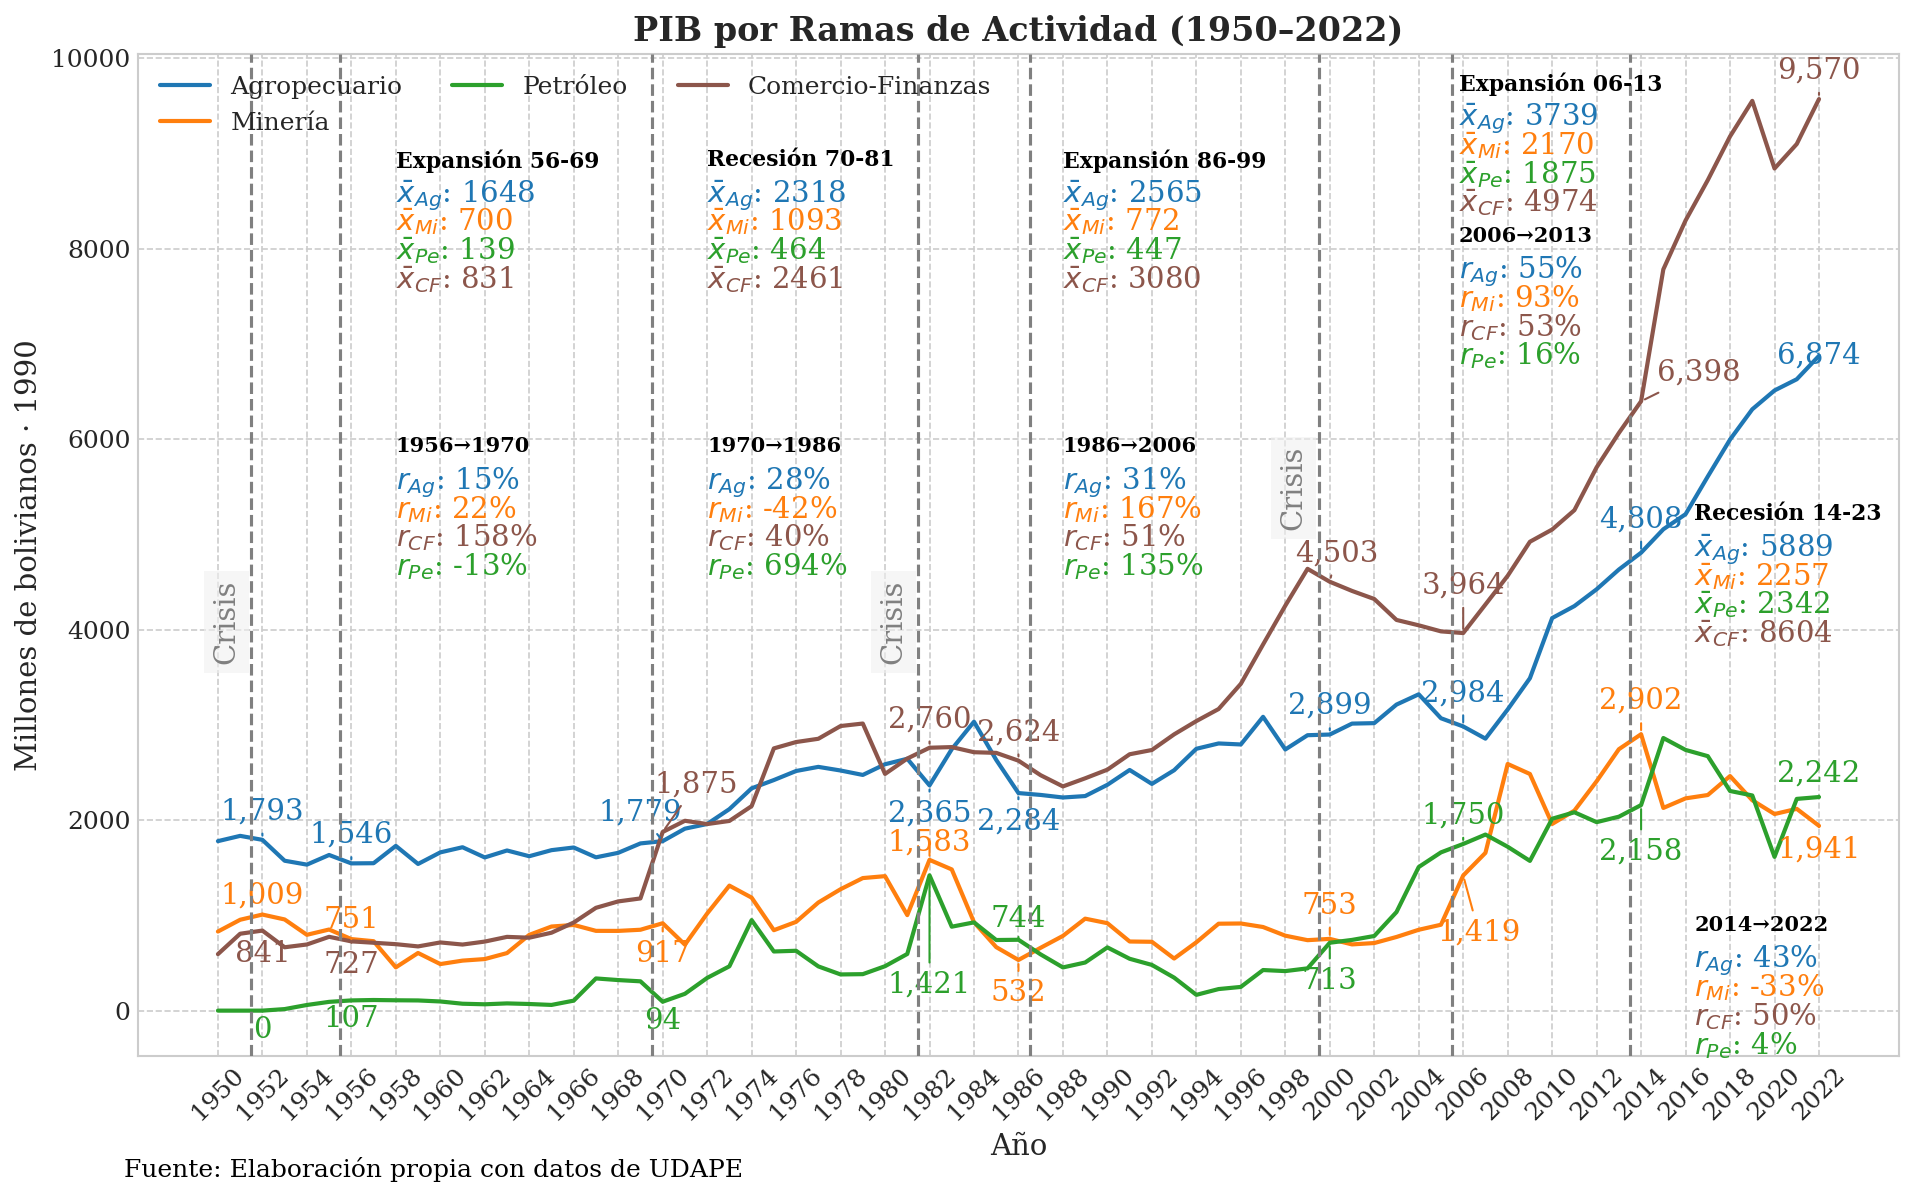

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3, os

def obtener_tasas_periodos(
    df: pd.DataFrame,
    componentes: list[str],
    periodos: list[tuple[int, int]]
) -> pd.DataFrame:
    """
    Calcula la tasa de crecimiento (%) de cada componente
    para los periodos (vi, vf) dados en `periodos`.

    - df: índice = año, columnas = componentes
    - componentes: lista de nombres de columnas en df
    - periodos: lista de tuplas (vi, vf)  ←  ⚠ ahora primero inicial, luego final

    Devuelve un DataFrame con índice "vi-vf" y columnas = componentes.
    """
    # Etiquetas de filas en el mismo orden que llegan los periodos
    filas = [f"{vi}-{vf}" for vi, vf in periodos]

    # DataFrame de salida
    out = pd.DataFrame(index=filas, columns=componentes, dtype=float)

    # Rellena con la tasa de crecimiento de cada componente
    for (vi, vf), etiqueta in zip(periodos, filas):
        out.loc[etiqueta] = (
            (df.loc[vf, componentes] / df.loc[vi, componentes] - 1) * 100
        ).round(1)

    return out  # mantiene el orden original de filas

CRISIS_52_55      = slice(1952, 1955)   # Crisis
EXPANSION_56_69   = slice(1956, 1969)   # Expansión
RECESION_70_81    = slice(1970, 1981)   # Recesión
CRISIS_82_85      = slice(1982, 1985)   # Crisis (neoliberal)
EXPANSION_86_99   = slice(1986, 1999)   # Expansión
CRISIS_00_05      = slice(2000, 2005)   # Crisis
ACUMULACION_06_13 = slice(2006, 2013)   # Acumulación (expansión)
RECESION_14_23    = slice(2014, 2024)   # Recesión
# ── 1. Configuración general ─────────────────────────────────────────
output_dir = "../../../../assets/tesis/serie_completa/pib"
os.makedirs(output_dir, exist_ok=True)

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family':'serif', 'font.size':12,
    'axes.titlesize':16,   'axes.labelsize':14,
    'grid.linestyle':'--', 'lines.linewidth':2,
    'figure.dpi':150,      'savefig.bbox':'tight'
})

# ── 2. Carga de datos ────────────────────────────────────────────────
with sqlite3.connect('../../../../db/proyectomacro.db') as conn:
    df = (pd.read_sql('SELECT * FROM pib_ramas', conn, index_col='año')
            .sort_index()) / 1000        # miles  → millones
#estadisticas
avg_expansion_56_69   = df.loc[EXPANSION_56_69].mean()
avg_recesion_70_81    = df.loc[RECESION_70_81].mean()
avg_expansion_86_99   = df.loc[EXPANSION_86_99].mean()
avg_expansion_06_13 = df.loc[ACUMULACION_06_13].mean()
avg_recesion_14_23    = df.loc[RECESION_14_23].mean()
# ── 3. Ramas de actividad ────────────────────────────────────────────
sectores = [
    ("agropecuario",             "Agropecuario"),
    ("mineria",                  "Minería"),
    ("petroleo",                 "Petróleo"),
    ("comercio_finanzas",        "Comercio-Finanzas"),
]

# ── 4. Hitos, años clave, offsets ────────────────────────────────────
hitos_v = {1951:"Crisis", 1955:"Expansion", 1969:"Recesion",
           1981:"Crisis", 1986:"Expansion", 1999:"Crisis",
           2005:"Expansion", 2013:"Recesion"}

anot_years = [1952,1956,1970,1982,1986,2000,2006,2014,2022]

# añade (dx,dy) solo si quieres mover textos manualmente
annotation_offsets = {
    "agropecuario": {
        1952: (0, 300), 1956: (0, 300), 1970: (-1, 300),
        1982: (0, -300), 1986: (0, -300), 2000: (0, 300),
        2006: (0, 350), 2014: (0, 350), 2022: (0, 0),
    },
    "mineria": {
        1952: (0, 200), 1956: (0, 200), 1970: (0, -320),
        1982: (0, 180), 1986: (0, -350), 2000: (0, 350),
        2006: (0.7, -600), 2014: (0, 350), 2022: (0, -250),
    },
    "petroleo": {
        1952: (0, -200), 1956: (0, -200), 1970: (0, -200),
        1982: (0, -1150), 1986: (0, 220), 2000: (0, -400),
        2006: (0, 300), 2014: (0, -490), 2022: (0, 250),
    },
    "comercio_finanzas": {
        1952: (0, -250), 1956: (0, -250), 1970: (1.5, 500),
        1982: (0, 300), 1986: (0, 300), 2000: (0.3, 300),
        2006: (0, 500), 2014: (2.6, 300), 2022: (0, 300),
    },
}
# hitos_offset: año → fracción de eje Y (0–1) donde apoya la base del recuadro
hitos_offset = {
    1951: 0.45, 1955: 0.50, 1969: 0.50,
    1981: 0.45, 1986: 0.50, 1999: 0.59,
    2005: 0.62, 2013: 0.48
}
annotation_tasas_offsets = {
    'agropecuario': {
        1970: (0,   9000),   # desplaza la etiqueta 1956→1970
        1986: (-2.3,  8900),   # desplaza la etiqueta 1970→1986
        2006: (-3.5,   800),   # desplaza la etiqueta 1986→2006
        2014: (-0.9,  -4600),   # desplaza la etiqueta 2006→2014
        2022: (1,-5200)
    }
}
# ── 5. Gráfico ───────────────────────────────────────────────────────
custom_colors = {
    "agropecuario":      "#1f77b4",  # blue
    "mineria":           "#ff7f0e",  # orange
    "petroleo":          "#2ca02c",  # green
    "comercio_finanzas": "#8c564b",  # café
}

fig, ax = plt.subplots(figsize=(13,8))
for col, label in sectores:
    ax.plot(df.index, df[col],
            label=label,
            color=custom_colors[col])

# ── 6. Dibujar líneas verticales de hitos ───────────────────────────
for yr, lbl in hitos_v.items():
    if yr in df.index:
        ax.axvline(x=yr+0.5, color='gray', linestyle='--', linewidth=1.5, zorder=5)
        y_max = ax.get_ylim()[1]
        offset = hitos_offset.get(yr, 0.82)   # fallback si falta
        if lbl=='Crisis':
            ax.text(yr, y_max * offset, lbl,
                    rotation=90, ha='right', va='top',
                    fontsize=14, color='gray',
                    bbox=dict(facecolor='#f0f0f0', alpha=0.6, edgecolor='none'),
                    zorder=6)

# ── 7. Anotaciones de valores ────────────────────────────────────────
for yr in anot_years:
    if yr not in df.index:
        continue
    vals = [(df.loc[yr, col], col) for col, _ in sectores]
    vals.sort(key=lambda t: t[0])  # de menor a mayor
    for y, col in vals:
        dx, dy = annotation_offsets.get(col, {}).get(yr, (0, 0))
        ax.annotate(f"{y:,.0f}",
                    xy=(yr, y), xytext=(yr + dx, y + dy),
                    ha='center', va='center',
                    fontsize=14, color=custom_colors[col],
                    arrowprops=dict(arrowstyle='-',
                                    color=custom_colors[col], lw=1))
        
# Mapa de tasas por año final
periodos = [
    (1956, 1970),
    (1970, 1986),
    (1986, 2006),
    (2006, 2013),
    (2014, 2022)
]
componentes = ["agropecuario", "mineria", "comercio_finanzas", "petroleo"]

tasas = obtener_tasas_periodos(df, componentes, periodos)

#cuadro de estadisticas
# 8.1 Abreviaturas para las ramas
abbr = {
    "agropecuario":      "Ag",
    "mineria":           "Mi",
    "petroleo":          "Pe",
    "comercio_finanzas": "CF",
}

# 8.2 Estadísticas promedio por ciclo (ya calculadas arriba)
cycle_stats = {
    "Expansión 56-69": avg_expansion_56_69,
    "Recesión 70-81":  avg_recesion_70_81,
    "Expansión 86-99": avg_expansion_86_99,
    "Expansión 06-13": avg_expansion_06_13,
    "Recesión 14-23":  avg_recesion_14_23,
}

# 8.3 Colores de cada rama (mismo diccionario de la línea)
component_colors = custom_colors

# 8.4 Posiciones de los cuadros dentro del área de datos
y_max = ax.get_ylim()[1]
line_spacing = y_max * 0.03

text_offsets = {
    "Expansión 56-69": (1958, y_max * 0.90),
    "Recesión 70-81":  (1972, y_max * 0.90),
    "Expansión 86-99": (1988, y_max * 0.90),
    "Expansión 06-13": (2005.8, y_max * 0.98),
    "Recesión 14-23":  (2016.4, y_max * 0.53),
}

for name, stats in cycle_stats.items():
    x0, y0 = text_offsets[name]
    # 1) Título del ciclo
    ax.text(
        x0, y0, name,
        ha='left', va='top',
        fontsize=10.5, fontweight='bold', color='black',
        zorder=7
    )
    # 2) Una línea por cada rama, con su color
    for j, col in enumerate(abbr):
        val = int(round(stats[col]))
        ax.text(
            x0, y0 - (j+1)*line_spacing,
            fr"$\bar{{x}}_{{{abbr[col]}}}$: {val}",
            ha='left', va='top',
            fontsize=14, color=component_colors[col],
            zorder=7
        )
tasas_df = obtener_tasas_periodos(df, componentes, periodos)

# 2. Parámetros de posición y estilo (sobre tu ax ya dibujado)
y_max       = ax.get_ylim()[1]
line_space  = y_max * 0.03
# abreviaturas para cada componente
abbr_comp   = {
    "agropecuario":      "Ag",
    "mineria":           "Mi",
    "comercio_finanzas": "CF",
    "petroleo":          "Pe",
}
# 3. Coordenadas aproximadas para cada periodo
period_offsets = {
    "1956-1970": (1958,  y_max * 0.60),
    "1970-1986": (1972,  y_max * 0.60),
    "1986-2006": (1988,  y_max * 0.60),
    "2006-2013": (2005.8,  y_max * 0.82),
    "2014-2022": (2016.4,y_max * 0.1),
}

# 4. Loop para anotar cada cuadro de tasas
for periodo, row in tasas_df.iterrows():
    x0, y0 = period_offsets[periodo]
    # Título del periodo
    ax.text(
        x0, y0, periodo.replace("-", "→"),
        ha='left', va='top',
        fontsize=10, fontweight='bold',
        color='black', zorder=7
    )
    # Cada componente en su color
    for i, comp in enumerate(componentes):
        ax.text(
            x0,
            y0 - (i+1)*line_space,
            fr"$r_{{{abbr_comp[comp]}}}$: {row[comp]:.0f}%",
            ha='left', va='top',
            fontsize=  14,
            color=component_colors[comp],
            zorder=7
            )
# ── 8. Ajustes finales ───────────────────────────────────────────────
ax.set_title(f"PIB por Ramas de Actividad ({df.index[0]}–{df.index[-1]})",
             fontweight='bold')
ax.set_xlabel("Año")
ax.set_ylabel("Millones de bolivianos · 1990")
ax.set_xticks(df.index[::max(1,len(df)//31)])
ax.tick_params(axis='x', rotation=45)
ax.legend(loc='upper left', ncol=3, fontsize=12)
# ── Pie de fuente ─────────────────────────────────────────────────────────
fig.text(
    0.07, 0.005,
    "Fuente: Elaboración propia con datos de UDAPE",
    ha="left", va="bottom",
    fontsize=12, color="black",
    transform=fig.transFigure
)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "pib_ramas_extended.png"))
plt.show()
